In [159]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta, datetime
from scipy.optimize import minimize

In [160]:
tickers = ['SPY', 'GLD', 'BND', 'QQQ', 'VTI']



In [161]:
endDate = datetime.today()

In [162]:
startDate = endDate - timedelta(days = 8*365)

In [163]:
startDate,endDate

(datetime.datetime(2017, 7, 4, 19, 3, 54, 995359),
 datetime.datetime(2025, 7, 2, 19, 3, 54, 995359))

In [164]:
adjClosedDf = pd.DataFrame()

In [165]:
for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adjClosedDf[ticker] = data['Close']

adjClosedDf

/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_49348/299834994.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startDate, end = endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_49348/299834994.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startDate, end = endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_49348/299834994.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startDate, end = endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_49348/299834994.py:2: FutureWarning: YF.download() has changed argum

,SPY,GLD,BND,QQQ,VTI
Date,,,,,
2017-07-05,213.335724,116.519997,64.799820,130.281403,109.696579
2017-07-06,211.384888,116.470001,64.648849,129.106766,108.616196
2017-07-07,212.755737,115.279999,64.632965,130.499298,109.371567
2017-07-10,212.984192,115.470001,64.664726,131.351791,109.450607
2017-07-11,212.826050,115.620003,64.728302,131.721268,109.424248
...,...,...,...,...,...
2025-06-26,611.869995,306.779999,73.275383,546.219971,301.031128
2025-06-27,614.909973,301.220001,73.105919,548.090027,302.397003
2025-06-30,617.849976,304.829987,73.394997,551.640015,303.929993


In [166]:
adjClosedDf

,SPY,GLD,BND,QQQ,VTI
Date,,,,,
2017-07-05,213.335724,116.519997,64.799820,130.281403,109.696579
2017-07-06,211.384888,116.470001,64.648849,129.106766,108.616196
2017-07-07,212.755737,115.279999,64.632965,130.499298,109.371567
2017-07-10,212.984192,115.470001,64.664726,131.351791,109.450607
2017-07-11,212.826050,115.620003,64.728302,131.721268,109.424248
...,...,...,...,...,...
2025-06-26,611.869995,306.779999,73.275383,546.219971,301.031128
2025-06-27,614.909973,301.220001,73.105919,548.090027,302.397003
2025-06-30,617.849976,304.829987,73.394997,551.640015,303.929993


In [167]:
logReturns = np.log(adjClosedDf/adjClosedDf.shift(1))

In [168]:
logReturns = logReturns.dropna()

Calculate covariance Matrix, measures the 'risk'. to calculate st deviation.


In [169]:
covMatrix = logReturns.cov()*252
covMatrix

,SPY,GLD,BND,QQQ,VTI
SPY,0.037578,0.002572,0.001738,0.043468,0.038170
GLD,0.002572,0.021010,0.002886,0.003502,0.002707
BND,0.001738,0.002886,0.003530,0.002079,0.001853
QQQ,0.043468,0.003502,0.002079,0.057389,0.044091
VTI,0.038170,0.002707,0.001853,0.044091,0.039074


Portfolio performance metrics

In [170]:
def standardDeviation(weights, covMatrix):
    variance = weights.T @ covMatrix @ weights
    return np.sqrt(variance)


Calculate expected return





In [171]:
def expectedReturn(weights, logReturns):
    return np.sum(logReturns.mean()*weights)*252

Calculate SharpeRatio


In [172]:
def sharpeRatio(weights, logReturns, covMatrix, riskFreeRate):
    return((expectedReturn(weights, logReturns)-riskFreeRate)/standardDeviation(weights,covMatrix))

Use federal reserve API for riskfree rate

In [173]:
import fredapi
riskFreeRate = 0.036

In [174]:
!pip install fredapi

zsh:1: command not found: pip


In [175]:
import sys
!{sys.executable} -m pip install fredapi


In [176]:
from fredapi import Fred

In [177]:
def negSharpeRatio(weights, logReturns, covMatrix, riskFreeRate):
    return-(sharpeRatio(weights,logReturns,covMatrix,riskFreeRate))

Making Constraints

In [178]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}

In [179]:
bounds = [(0,0.4)for _ in range(len(tickers))]


set initial weights


In [180]:
initialWeights = np.array([1/len(tickers)]*len(tickers))
initialWeights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [181]:
optimizedResults = minimize(negSharpeRatio, initialWeights, args=(logReturns,covMatrix,riskFreeRate), method='SLSQP', constraints=constraints, bounds=bounds)

In [182]:
optimalWeights = optimizedResults.x

Display weights

In [183]:
print("Optimal Weights:")
for ticker,weight in zip(tickers, optimalWeights):
    print(f"{ticker}: {weight:.4f}")
print()
opr = expectedReturn(optimalWeights, logReturns)
opv = standardDeviation(optimalWeights, covMatrix)
opsr = sharpeRatio(optimalWeights,logReturns,covMatrix,riskFreeRate)

print(f"Expected annual return: {opr:.4f}")
print(f"Expected Volatility: {opv:.4f}")
print(f"Sharpe Ratio: {opsr:.4f}")

Optimal Weights:
SPY: 0.2000
GLD: 0.4000
BND: 0.0000
QQQ: 0.4000
VTI: 0.0000

Expected annual return: 0.1478
Expected Volatility: 0.1501
Sharpe Ratio: 0.7451


In [184]:
import matplotlib.pyplot as plt


<function matplotlib.pyplot.show(close=None, block=None)>

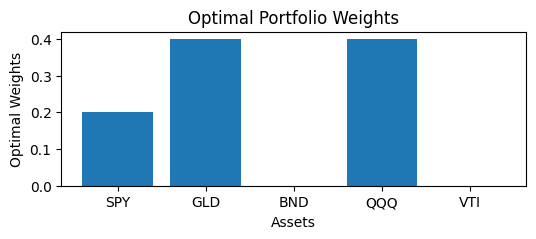

In [185]:
plt.figure(figsize=(6,2))
plt.bar(tickers, optimalWeights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show